In [1]:
import pennylane as qml
import pennylane.numpy as np
from pennylane.transforms import mitigate_with_zne  # ZNE implementation using pennylane
import networkx as nx

from matplotlib import pyplot as plt

<class 'pennylane.ops.qubit.hamiltonian.Hamiltonian'>


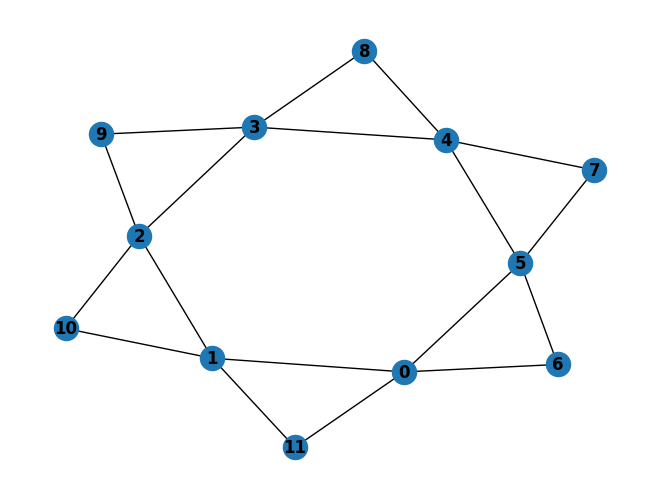

In [4]:
graph = nx.Graph(((0, 1), (1, 2), (2, 3), (3, 4),(4,5),(5,0),(6,0),(6,5),(7,5),(7,4),(8,4),(8,3),(9,3),(9,2),(10,2),(10,1),(1,11),(11,0)))
from pennylane.qaoa import maxcut
hamiltonian_maxcut, hamiltonian_mixer = maxcut(graph)
print(type(hamiltonian_maxcut))
nx.draw(graph, with_labels=True, font_weight='bold')

In [5]:
obs = []
coeffs = []

for edge in graph.edges():
    coeffs.extend([1.0, 1.0, 1.0])
    obs.extend([qml.PauliX(edge[0]) @ qml.PauliX(edge[1]),
                        qml.PauliY(edge[0]) @ qml.PauliY(edge[1]),
                        qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])])
hamiltonian_heisenberg = qml.Hamiltonian(coeffs, obs)
print(hamiltonian_heisenberg)
num_qubits = len(hamiltonian_heisenberg.wires)
print("\nVector space dimension of the ansatz circuit : ", num_qubits)

  (1.0) [X0 X1]
+ (1.0) [Y0 Y1]
+ (1.0) [Z0 Z1]
+ (1.0) [X0 X5]
+ (1.0) [Y0 Y5]
+ (1.0) [Z0 Z5]
+ (1.0) [X0 X6]
+ (1.0) [Y0 Y6]
+ (1.0) [Z0 Z6]
+ (1.0) [X0 X11]
+ (1.0) [Y0 Y11]
+ (1.0) [Z0 Z11]
+ (1.0) [X1 X2]
+ (1.0) [Y1 Y2]
+ (1.0) [Z1 Z2]
+ (1.0) [X1 X10]
+ (1.0) [Y1 Y10]
+ (1.0) [Z1 Z10]
+ (1.0) [X1 X11]
+ (1.0) [Y1 Y11]
+ (1.0) [Z1 Z11]
+ (1.0) [X2 X3]
+ (1.0) [Y2 Y3]
+ (1.0) [Z2 Z3]
+ (1.0) [X2 X9]
+ (1.0) [Y2 Y9]
+ (1.0) [Z2 Z9]
+ (1.0) [X2 X10]
+ (1.0) [Y2 Y10]
+ (1.0) [Z2 Z10]
+ (1.0) [X3 X4]
+ (1.0) [Y3 Y4]
+ (1.0) [Z3 Z4]
+ (1.0) [X3 X8]
+ (1.0) [Y3 Y8]
+ (1.0) [Z3 Z8]
+ (1.0) [X3 X9]
+ (1.0) [Y3 Y9]
+ (1.0) [Z3 Z9]
+ (1.0) [X4 X5]
+ (1.0) [Y4 Y5]
+ (1.0) [Z4 Z5]
+ (1.0) [X4 X7]
+ (1.0) [Y4 Y7]
+ (1.0) [Z4 Z7]
+ (1.0) [X4 X8]
+ (1.0) [Y4 Y8]
+ (1.0) [Z4 Z8]
+ (1.0) [X5 X6]
+ (1.0) [Y5 Y6]
+ (1.0) [Z5 Z6]
+ (1.0) [X5 X7]
+ (1.0) [Y5 Y7]
+ (1.0) [Z5 Z7]

Vector space dimension of the ansatz circuit :  12


In [6]:
n_layers = 2

#initial
w1 = np.ones((num_qubits), requires_grad=True)
w2 = np.ones((n_layers, num_qubits - 1, 2), requires_grad=True)

def ansatz_cost(w1, w2):
    qml.SimplifiedTwoDesign(w1, w2, wires=range(num_qubits))
    return qml.expval(hamiltonian_heisenberg)

print(qml.draw(ansatz_cost)(w1,w2))

 0: ─╭SimplifiedTwoDesign─┤ ╭<𝓗>
 1: ─├SimplifiedTwoDesign─┤ ├<𝓗>
 2: ─├SimplifiedTwoDesign─┤ ├<𝓗>
 3: ─├SimplifiedTwoDesign─┤ ├<𝓗>
 4: ─├SimplifiedTwoDesign─┤ ├<𝓗>
 5: ─├SimplifiedTwoDesign─┤ ├<𝓗>
 6: ─├SimplifiedTwoDesign─┤ ├<𝓗>
 7: ─├SimplifiedTwoDesign─┤ ├<𝓗>
 8: ─├SimplifiedTwoDesign─┤ ├<𝓗>
 9: ─├SimplifiedTwoDesign─┤ ├<𝓗>
10: ─├SimplifiedTwoDesign─┤ ├<𝓗>
11: ─╰SimplifiedTwoDesign─┤ ╰<𝓗>


In [7]:
# Depolarizing noise
noise_gate = qml.DepolarizingChannel
noise_strength = 0.025

dev_ideal = qml.device("default.mixed", wires=num_qubits)
dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength, position="all")

scale_factors=[1, 2]


qnode_ideal = qml.QNode(ansatz_cost, dev_ideal) # ideal qnode
qnode_noisy = qml.QNode(ansatz_cost, dev_noisy) #noisy qnode
qnode_mitigated = mitigate_with_zne(qnode_noisy,
    scale_factors=scale_factors,
    folding=qml.transforms.fold_global,
    extrapolate=qml.transforms.richardson_extrapolate,
) # mitigated qnode

In [ ]:
ideal_res = qnode_ideal(w1, w2)
print("Ideal QNode: ", ideal_res)
noisy_res = qnode_noisy(w1, w2)
print("Noisy QNode: ", noisy_res)
mitigated_res = qnode_mitigated(w1,w2)
print("Mitigated QNode: ", mitigated_res)

Ideal QNode:  0.7875308867384113


In [ ]:
%%time

def VQE_run(cost_fn, max_iter, stepsize=0.1):
    """VQE Optimization loop"""
    opt = qml.SPSAOptimizer(maxiter= max_iter)

    # fixed initial guess
    w1 = np.ones((num_qubits), requires_grad=True)
    w2 = np.ones((n_layers, num_qubits - 1, 2), requires_grad=True)

    energy = []

    # Optimization loop
    for n in range(max_iter):
        (w1, w2), prev_energy = opt.step_and_cost(cost_fn, w1, w2)

        energy.append(prev_energy)
        if (n%50 == 0):
          print("Energy optimization at ",n,"th step is : ",energy[-1])

    energy.append(cost_fn(w1, w2)) # final addition to the last updated params
    print("\n")
    return energy # energy list


max_iter = 200

energy_ideal = VQE_run(qnode_ideal, max_iter)
energy_noisy = VQE_run(qnode_noisy, max_iter)
energy_mitigated = VQE_run(qnode_mitigated, max_iter)

energy_exact = np.min(np.linalg.eigvalsh(qml.matrix(hamiltonian_heisenberg)))

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(energy_noisy, "--.", label="VQE E_noisy",color= "blue",linewidth = 0.9)
plt.plot(energy_mitigated, "--.", label="VQE E_mitigated", color = "black",linewidth = 0.9)
plt.plot(energy_ideal, "--.", label="VQE E_ideal", color = "green",linewidth = 0.9)
plt.plot([1, max_iter + 1], [energy_exact] * 2, "--", label="E_exact", color = "red")
plt.legend(fontsize=10)
plt.xlabel("Iteration", fontsize=10)
plt.ylabel("Energy", fontsize=10)
plt.show()